In [8]:
import rasterio
import boto3
import xarray as xr
import numpy as np
import re
from datacube.utils.dask import start_local_dask
from datacube import Datacube
from datacube.utils.geometry import CRS, Geometry, GeoBox
from datacube.testutils.io import native_geobox, native_load
from osgeo import ogr, gdal, osr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import fiona
from scipy import ndimage
import dask.array as da
from scipy.spatial.distance import cdist

In [6]:
def generate_seamask(shape_file, data_shape, data_crs, orig_coords, resolution):
    """
        creak mask without oceans
        input:
            shape_file: the shape file of Australia coastline
            data_shape: the shape of loaded data to be masked upon
            orig_coords: the origin of the image for gdal to decide the transform
            resolution: pixel size with signs, e.g., (30, -30) for C3 and (25, -25) for C2
        output:
            a numpy array of mask, where valid pixels = 1
    """
    source_ds = ogr.Open(shape_file)
    source_layer = source_ds.GetLayer()
    source_layer.SetAttributeFilter("FEAT_CODE!='sea'")

    yt, xt = data_shape
    xres = resolution[0]
    yres = resolution[1]
    no_data = 0

    xcoord, ycoord = orig_coords
    geotransform = (xcoord - (xres*0.5), xres, 0, ycoord - (yres*0.5), 0, yres)

    target_ds = gdal.GetDriverByName('MEM').Create('', xt, yt, gdal.GDT_Byte)
    target_ds.SetGeoTransform(geotransform)
    albers = osr.SpatialReference()
    albers.ImportFromEPSG(int(data_crs))
    target_ds.SetProjection(albers.ExportToWkt())
    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(no_data)

    gdal.RasterizeLayer(target_ds, [1], source_layer, burn_values=[1])
    return band.ReadAsArray()

In [7]:
def native_load_dss(dss, measurements):
    geobox = native_geobox(
            dss[0], basis=list(dss[0].measurements.keys())[0]
        )
    mm = dss[0].type.lookup_measurements(measurements)
    tmp_data = Datacube.load_data(Datacube.group_datasets(dss, 'solar_day'),
                    geobox, measurements=mm, dask_chunks={'time': -1, 'x': 400, 'y': 400})
        
    return tmp_data

In [1]:
def landsat_scene_poly(landsat_shape, region_code):
    with fiona.open(landsat_shape) as all_shapes:
        for s in all_shapes:
            if s['properties'].get('PR') == region_code:
                if len(str(region_code)) < 6:
                    rc = '0' + str(region_code)
                else:
                    rc = str(region_code)
                return {rc: Geometry(dict(s['geometry']), crs=CRS('EPSG:4326'))}

In [9]:
def detect_cloud_edge(cloud_shadow_mask):
    erosion_struct = ndimage.generate_binary_structure(2, 1)
    tmpe = []
    for c in cloud_shadow_mask:
        cloud_erosion = da.map_blocks(ndimage.binary_erosion, c.data, erosion_struct, dtype=int)
        tmpe += [cloud_erosion ^ c]
    return xr.concat(tmpe, dim="time")  

In [10]:
def erode_dilate_cloud_shadow(func, cloud_shadow_mask, dilation_size):
    erosion_struct = ndimage.generate_binary_structure(2, 1)
    cloud_shadow_dilated = []
    if dilation_size > 0:
        dilation_struct = ndimage.iterate_structure(erosion_struct, dilation_size)
        for c in cloud_shadow_mask:
            cloud_shadow_dilated += [da.map_blocks(func, c.data, dilation_struct, dtype=int)]
        return xr.DataArray(da.stack(cloud_shadow_dilated), dims=['time', 'y', 'x'],
                            coords={'time': cloud_shadow_mask.time, 'y': cloud_shadow_mask.y, 
                                    'x': cloud_shadow_mask.x})
    else:
        for c in cloud_shadow_mask:
            cloud_shadow_dilated += [c.data.copy()]
        return xr.DataArray(da.stack(cloud_shadow_dilated), dims=['time', 'y', 'x'],
                            coords={'time': cloud_shadow_mask.time, 'y': cloud_shadow_mask.y, 
                                    'x': cloud_shadow_mask.x})

In [11]:
def generate_idx(cloud_mask, shadow_mask=None, dilation_size=0):
    if shadow_mask is not None:
        cloud_shadow_mask = cloud_mask | shadow_mask
    else:
        cloud_shadow_mask = cloud_mask
    if isinstance(dilation_size, int):
        cloud_shadow_dilated = erode_dilate_cloud_shadow(ndimage.binary_dilation, cloud_shadow_mask, dilation_size)
    else:
        print(f"dilate cloud with {dilation_size[0]}")
        cloud_dilated = erode_dilate_cloud_shadow(ndimage.binary_dilation, cloud_mask, dilation_size[0])
        print(f"dilate shadow with {dilation_size[1]}")
        shadow_dilated = erode_dilate_cloud_shadow(ndimage.binary_dilation, shadow_mask, dilation_size[1])
        cloud_shadow_dilated = cloud_dilated | shadow_dilated
        
    tmpe = detect_cloud_edge(cloud_shadow_mask)
    tmpe_dilated = detect_cloud_edge(cloud_shadow_dilated)
    edge_normal_indx = []
    edge_cloud_indx = []
    for c in cloud_shadow_dilated:
        edge_normal_indx += [da.map_blocks(ndimage.distance_transform_edt, c.data, 
                                           return_distances=False, return_indices=True,
                                           new_axis=0, chunks=(2,)+c.data.shape)]
    
    for c in (tmpe | ~cloud_shadow_mask):
        edge_cloud_indx += [da.map_blocks(ndimage.distance_transform_edt, c.data, 
                                          return_distances=False, return_indices=True,
                                          new_axis=0, chunks=(2,)+c.data.shape)]

    edge_normal_indx = xr.DataArray(da.stack(edge_normal_indx), dims=['time', 'idx', 'y', 'x'],
                               coords={'time': cloud_shadow_mask.time, 'idx': [0, 1],
                                       'y': cloud_shadow_mask.y, 'x': cloud_shadow_mask.x})
    edge_cloud_indx = xr.DataArray(da.stack(edge_cloud_indx), dims=['time', 'idx', 'y', 'x'],
                               coords={'time': cloud_shadow_mask.time, 'idx': [0, 1],
                                       'y': cloud_shadow_mask.y, 'x': cloud_shadow_mask.x})
    cloud_ids = edge_cloud_indx.where(tmpe, 0)
    normal_ids = edge_normal_indx.where(tmpe_dilated, 0)
    return cloud_ids, normal_ids, cloud_shadow_dilated

In [78]:
def poly_from_region_code(region_code, grids_file):
    with fiona.open(grids_file) as allshapes:
        for shape in allshapes:
            if shape['properties'].get('region_code', '') == region_code.lower():
                return Geometry(shape['geometry'], crs=CRS('EPSG:4326'))

In [4]:
def locate_landsat_scene(landsat_shape, grid_shape, grid_id):
    ds_landsat = ogr.Open(landsat_shape)
    lyr_landsat = ds_landsat.GetLayer(0)
    lyr_landsat.ResetReading()
    ds_grid = ogr.Open(grid_shape)
    lyr_grid = ds_grid.GetLayer(0)
    lyr_grid.ResetReading()
    for grid in lyr_grid:
        if grid['region_code'] == grid_id:
            break
    lyr_landsat.SetSpatialFilter(grid.geometry())
    query_poly = {}
    for l in lyr_landsat:
        query_poly[l['PR']] = Geometry(shapely.wkt.loads(l.geometry().ExportToWkt()), crs=CRS('EPSG:4326'))
    return query_poly

In [137]:
if client:
    client.close()
client = start_local_dask(n_workers=1, threads_per_worker=60, memory_limit='400GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/emma.ai@ga.gov.au/proxy/8787/status,
Dashboard: /user/emma.ai@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 60,Total memory: 372.53 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39107,Workers: 1
Dashboard: /user/emma.ai@ga.gov.au/proxy/8787/status,Total threads: 60
Started: Just now,Total memory: 372.53 GiB
Comm: tcp://127.0.0.1:35099,Total threads: 60
Dashboard: /user/emma.ai@ga.gov.au/proxy/34255/status,Memory: 372.53 GiB
Nanny: tcp://127.0.0.1:39957,


In [6]:
landsat_shape = "./landsat_au/landsat_au.shp"
grid_shape = "./au-grid.geojson"
au_shape = "./aus_map/cstauscd_r.shp"
dc = Datacube()

NameError: name 'Datacube' is not defined

In [24]:
sample_pr = 113072
query_poly_dict = landsat_scene_poly(landsat_shape, sample_pr)
for region_code, query_poly in query_poly_dict.items():
    c3_query = {'geopolygon': query_poly}
    # c3_query['region_code'] = region_code
    # for year in range(2014, 2022):
    c3_query['time'] = (str(2021)+'-11-01', str(2021)+'-12-01')
    
    c3_ls8_datasets = dc.find_datasets(product='ga_ls8c_ard_3', **c3_query)
    c3_ls8_datasets.sort(key=lambda x: x.center_time)
    ls8_bands = ["blue", "green", "red", "nir", "swir1", "swir2", "fmask"]
    # c3_ls8 = native_load_dss(c3_ls8_datasets, ls8_bands)

In [65]:
(region_code, ) + query_poly.geom.bounds

('113072', 117.556, -18.2303, 119.62, -16.4619)

In [25]:

    c3_ls9_datasets = dc.find_datasets(product='ga_ls9c_ard_3', **c3_query, region_code=region_code)
    c3_ls9_datasets.sort(key=lambda x: x.center_time)
    ls8_bands = ["blue", "green", "red", "nir", "swir1", "swir2", "fmask"]

In [52]:
    c3_ls8_datasets = dc.find_datasets(product='ga_ls8c_ard_3', geopolygon=c3_query["geopolygon"],
                                      time=(c3_ls9_datasets[0].center_time - timedelta(days=1), c3_ls9_datasets[-1].center_time - timedelta(days=1)))
    c3_ls8_datasets.sort(key=lambda x: x.center_time)

In [15]:
sample_pr = 91089

query_poly_dict = landsat_scene_poly(landsat_shape, sample_pr)
for region_code, query_poly in query_poly_dict.items():
    c3_query = {'geopolygon': query_poly}
    c3_query['region_code'] = region_code
    # for year in range(2014, 2022):
    c3_query['time'] = (str(2019)+'-01-01', str(2021)+'-01-01')
    c3_ls8_datasets = dc.find_datasets(product='ga_ls8c_ard_3', **c3_query)
    c3_ls8_datasets.sort(key=lambda x: x.center_time)
    ls8_bands = ["blue", "green", "red", "nir", "swir1", "swir2", "fmask"]
    c3_ls8 = native_load_dss(c3_ls8_datasets, ls8_bands)


# cloud_shadow_dialated = erode_dilate_cloud_shadow(ndimage.binary_dilation, (cloud_mask | shadow_mask), 5)
# cloud.load()

In [168]:
c3_ls8_datasets[39]

Dataset <id=32924958-e93f-431b-a232-ce2be07fd788 product=ga_ls8c_ard_3 location=s3://dea-public-data/baseline/ga_ls8c_ard_3/091/089/2020/09/19/ga_ls8c_ard_3-1-0_091089_2020-09-19_final.stac-item.json>

In [16]:
c3_ls8

<xarray.Dataset>
Dimensions:      (time: 45, y: 7831, x: 7801)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-04T23:58:20.450895 ... 2020-12...
  * y            (y) float64 -4.506e+06 -4.506e+06 ... -4.741e+06 -4.741e+06
  * x            (x) float64 3.111e+05 3.111e+05 ... 5.451e+05 5.451e+05
    spatial_ref  int32 32655
Data variables:
    blue         (time, y, x) int16 dask.array<chunksize=(45, 400, 400), meta=np.ndarray>
    green        (time, y, x) int16 dask.array<chunksize=(45, 400, 400), meta=np.ndarray>
    red          (time, y, x) int16 dask.array<chunksize=(45, 400, 400), meta=np.ndarray>
    nir          (time, y, x) int16 dask.array<chunksize=(45, 400, 400), meta=np.ndarray>
    swir1        (time, y, x) int16 dask.array<chunksize=(45, 400, 400), meta=np.ndarray>
    swir2        (time, y, x) int16 dask.array<chunksize=(45, 400, 400), meta=np.ndarray>
    fmask        (time, y, x) uint8 dask.array<chunksize=(45, 400, 400), meta=np.ndarray>
Attributes:
    crs:           epsg:32655
    grid_mapping:  spatial_ref

In [17]:
from odc.algo._masking import xr_apply_morph_op

In [24]:
from odc.algo import mask_cleanup, enum_to_bool
from odc.algo._masking import _enum_to_mask_numexpr, mask_cleanup_np, _compute_overlap_depth, _get_enum_values
from odc.algo._dask import randomize
from functools import partial

In [20]:
def enum_to_bool_with_morph(mask_data, mask_filters):
    mask_morph = None
    for classes, _filters in mask_filters.items():       
        res_bool = _enum_to_mask_numexpr(mask_data, classes)
        if mask_morph is None:
            mask_morph = mask_cleanup_np(res_bool, _filters)
        else:
            mask_morph |= mask_cleanup_np(res_bool, _filters)
    return mask_morph


In [21]:
def enum_to_bool_with_morph_dask(mask, mask_filters, flag_name=""):
    data = mask.data
    rr = []
    for filters in mask_filters.values():
        rr += [radius for _, radius in filters]
    # rr = list(set(rr))
    print(rr)
    depth = _compute_overlap_depth(rr, data.ndim)
    print(depth)

    name = "mask_cleanup"
    for radius in rr:
        name = name + f"_{radius}"
    classes_filters = {}
    for categories, _filters in mask_filters.items():
        categories_s = tuple(c for c in categories if isinstance(c, str))
        classes = tuple(c for c in categories if isinstance(c, int))
        print(categories_s)
        if len(categories_s) > 0:
            flags = getattr(mask, "flags_definition", None)
            if flags is None:
                raise ValueError("Missing flags_definition attribute")

            classes = classes + _get_enum_values(categories_s, flags, flag=flag_name)
        classes_filters[classes] = _filters

    data = data.map_overlap(
        partial(enum_to_bool_with_morph, mask_filters=classes_filters),
        depth,
        boundary="none",
        name=randomize(name),
    )
    attrs = dict(mask.attrs)
    attrs.pop("flags_definition", None)
    attrs.pop("nodata", None)
    return xr.DataArray(data, attrs=attrs, coords=mask.coords, dims=mask.dims)

In [94]:
mask_filter = {("cloud", "shadow"): [("opening", 5), ("dilation", 6)]}

In [58]:
mask_filter = {("cloud",): [("opening", 5), ("dilation", 6)],
              # ("shadow",): [("dilation", 6)]
              }

In [131]:
mask_filter = {("cloud",): [("erosion", 5)],
              ("shadow",): [("dilation", 6)]
              }

In [132]:
cloud_mask_a = enum_to_bool(c3_ls8["fmask"], ("cloud", ))
shadow_mask_a = enum_to_bool(c3_ls8["fmask"], ("shadow", ))

In [133]:
cloud_mask_a = mask_cleanup(cloud_mask_a, mask_filter[("cloud", )])
shadow_mask_a = mask_cleanup(shadow_mask_a, mask_filter[("shadow", )])

In [134]:
mask_a = cloud_mask_a | shadow_mask_a

In [135]:
cloud_mask = (c3_ls8["fmask"] == 2)
shadow_mask = (c3_ls8["fmask"] == 3)
for ops, rr in mask_filter[("cloud",)]:
    cloud_mask = xr_apply_morph_op(cloud_mask, ops, rr)    
for ops, rr in mask_filter[("shadow",)]:
    shadow_mask = xr_apply_morph_op(shadow_mask, ops, rr) 

In [136]:
mask_b = cloud_mask | shadow_mask
# mask_b = cloud_mask

In [138]:
%time mask_a.load()

CPU times: user 26.3 s, sys: 3.6 s, total: 29.9 s
Wall time: 1min 47s


<xarray.DataArray (time: 45, y: 7831, x: 7801)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * time         (time) datetime64[ns] 2019-01-04T23:58:20.450895 ... 2020-12...
  * y            (y) float64 -4.506e+06 -4.506e+06 ... -4.741e+06 -4.741e+06
  * x            (x) float64 3.111e+05 3.111e+05 ... 5.451e+05 5.451e+05
    spatial_ref  int32 32655

In [139]:
%time mask_b.load()

CPU times: user 28.5 s, sys: 4.04 s, total: 32.6 s
Wall time: 1min 48s


<xarray.DataArray (time: 45, y: 7831, x: 7801)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * time         (time) datetime64[ns] 2019-01-04T23:58:20.450895 ... 2020-12...
  * y            (y) float64 -4.506e+06 -4.506e+06 ... -4.741e+06 -4.741e+06
  * x            (x) float64 3.111e+05 3.111e+05 ... 5.451e+05 5.451e+05
    spatial_ref  int32 32655

In [140]:
for i in range(mask_a.shape[0]):
    print(f"time {i}")
    print((mask_a[i] != mask_b[i]).sum().data)

time 0
0
time 1
0
time 2
0
time 3
0
time 4
0
time 5
0
time 6
0
time 7
682
time 8
842
time 9
86
time 10
1227
time 11
0
time 12
0
time 13
0
time 14
0
time 15
0
time 16
0
time 17
0
time 18
0
time 19
0
time 20
0
time 21
0
time 22
0
time 23
0
time 24
0
time 25
0
time 26
0
time 27
0
time 28
0
time 29
0
time 30
0
time 31
101
time 32
0
time 33
586
time 34
0
time 35
348
time 36
0
time 37
0
time 38
0
time 39
358
time 40
0
time 41
0
time 42
0
time 43
0
time 44
0


In [191]:
set(np.where((mask_a[39] != mask_b[39]))[0])

{6277,
 6278,
 6279,
 6280,
 6281,
 6282,
 6283,
 6284,
 6285,
 6286,
 6287,
 6288,
 6289,
 6290,
 6291,
 6292,
 6293,
 6294,
 6295,
 6296,
 6297,
 6298,
 6299,
 6300,
 6301,
 6302,
 6303,
 6304,
 6305,
 6306,
 6307,
 6308,
 6309,
 6310,
 6311,
 6312,
 6313,
 6314,
 6315,
 6316,
 6317,
 6318,
 6319,
 6320,
 6321,
 6322,
 6323,
 6324,
 6325,
 6326,
 6327,
 6328,
 6329,
 6330,
 6331,
 6332,
 6333,
 6334,
 6335,
 6336,
 6337,
 6338,
 6339,
 6340,
 6341,
 6342,
 6343,
 6344,
 6345,
 6346,
 6347,
 6348,
 6349}

In [166]:
c3_ls8["fmask"][39]

<xarray.DataArray 'fmask' (y: 7831, x: 7801)>
dask.array<getitem, shape=(7831, 7801), dtype=uint8, chunksize=(400, 400), chunktype=numpy.ndarray>
Coordinates:
    time         datetime64[ns] 2020-09-19T23:58:44.694354
  * y            (y) float64 -4.506e+06 -4.506e+06 ... -4.741e+06 -4.741e+06
  * x            (x) float64 3.111e+05 3.111e+05 ... 5.451e+05 5.451e+05
    spatial_ref  int32 32655
Attributes:
    units:             1
    nodata:            0
    flags_definition:  {'fmask': {'bits': [0, 1, 2, 3, 4, 5, 6, 7], 'values':...
    crs:               epsg:32655
    grid_mapping:      spatial_ref

In [173]:
c3_ls8.time

<xarray.DataArray 'time' (time: 45)>
array(['2019-01-04T23:58:20.450895000', '2019-01-20T23:58:17.166341000',
       '2019-02-05T23:58:14.211018000', '2019-02-21T23:58:11.435436000',
       '2019-03-09T23:58:06.142994000', '2019-03-25T23:58:02.355222000',
       '2019-04-10T23:57:57.827842000', '2019-04-26T23:57:52.020577000',
       '2019-05-12T23:58:01.389149000', '2019-05-28T23:58:10.611881000',
       '2019-06-13T23:58:17.557173000', '2019-06-29T23:58:22.391784000',
       '2019-07-15T23:58:25.243679000', '2019-07-31T23:58:31.574103000',
       '2019-08-16T23:58:37.076083000', '2019-09-01T23:58:40.614654000',
       '2019-09-17T23:58:45.996176000', '2019-10-03T23:58:50.326083000',
       '2019-10-19T23:58:52.194728000', '2019-11-04T23:58:51.333317000',
       '2019-11-20T23:58:47.578799000', '2019-12-06T23:58:47.262564000',
       '2019-12-22T23:58:44.462488000', '2020-01-07T23:58:40.371220000',
       '2020-01-23T23:58:36.549393000', '2020-02-08T23:58:31.552950000',
       '2020-02-24T23:58:27.804460000', '2020-03-11T23:58:21.478156000',
       '2020-03-27T23:58:12.732983000', '2020-04-12T23:58:05.328677000',
       '2020-04-28T23:57:57.571549000', '2020-05-14T23:57:53.503385000',
       '2020-05-30T23:57:57.618292000', '2020-06-15T23:58:07.677926000',
       '2020-07-01T23:58:15.649236000', '2020-07-17T23:58:21.644827000',
       '2020-08-02T23:58:25.726073000', '2020-08-18T23:58:31.282166000',
       '2020-09-03T23:58:39.087316000', '2020-09-19T23:58:44.694354000',
       '2020-10-05T23:58:47.950743000', '2020-10-21T23:58:48.533161000',
       '2020-11-22T23:58:47.910820000', '2020-12-08T23:58:49.682214000',
       '2020-12-24T23:58:47.422211000'], dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2019-01-04T23:58:20.450895 ... 2020-12...
    spatial_ref  int32 32655
Attributes:
    units:    seconds since 1970-01-01 00:00:00

2023-10-31 07:22:49,337 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-10-31 07:22:52,099 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-10-31 07:22:52,966 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-10-31 07:22:54,020 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-10-31 07:22:55,050 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-10-31 07:22:57,840 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-10-31 07:23:03,954 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-10-31 07:23:10,335 - distributed.utils_perf - WARNING - full garbage collections took

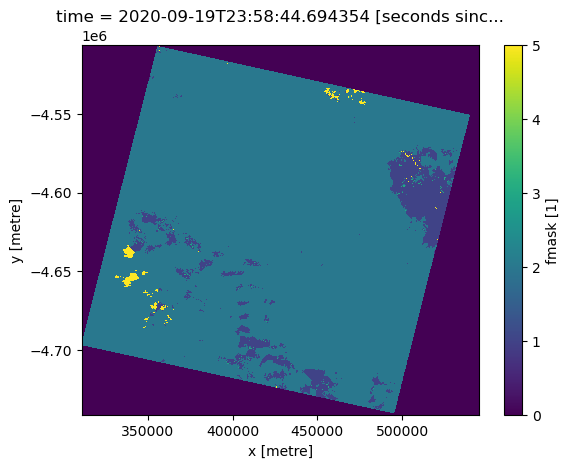

In [174]:
(c3_ls8["fmask"])[39].plot.imshow()

2023-10-31 07:30:51,849 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-10-31 07:30:52,977 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


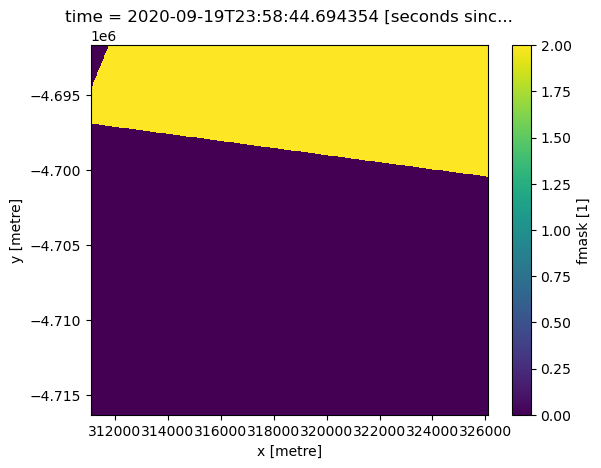

In [182]:
c3_ls8["fmask"][39][6180:7000,0:500].plot.imshow()

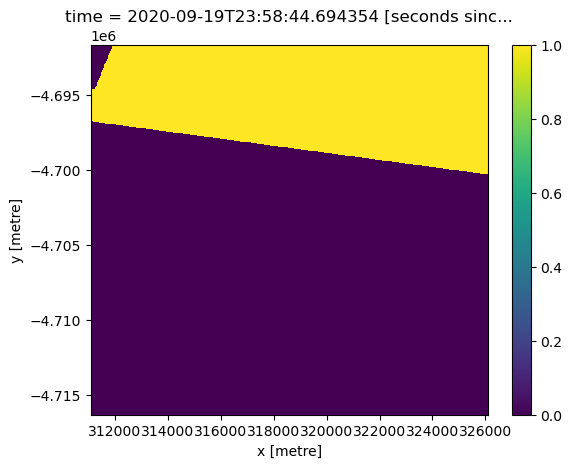

In [183]:
mask_a[39][6180:7000,0:500].plot.imshow()

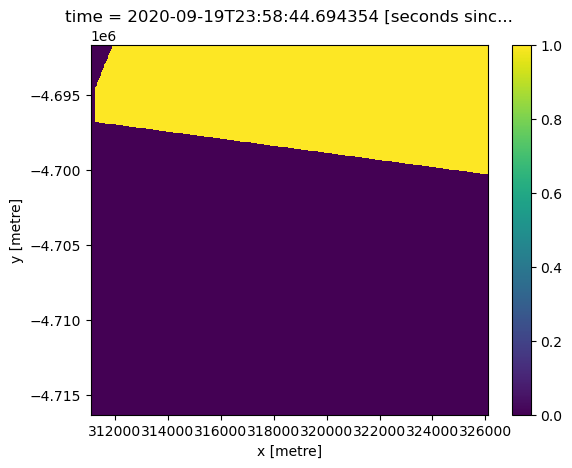

In [186]:
mask_b[39][6180:7000,0:500].plot.imshow()

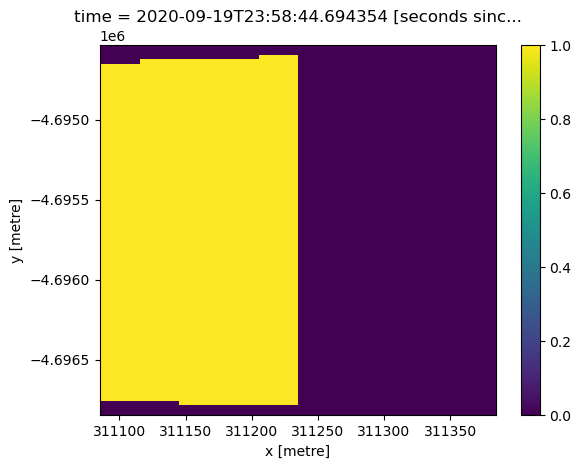

In [196]:
(mask_a[39][6275:6352,0:10] != mask_b[39][6275:6352,0:10]).plot.imshow()

In [189]:
mask_f = None
for _key, _filter in mask_filter.items():
    mask = enum_to_bool(c3_ls8["fmask"], _key)
    if mask_f is None:
        mask_f = mask_cleanup(mask, _filter)
    else:
        mask_f |= mask_cleanup(mask, _filter)

In [190]:
%time mask_f.compute()

CPU times: user 1.81 s, sys: 2.89 s, total: 4.7 s
Wall time: 42.7 s


<xarray.DataArray '_trim-e4d6f561f22f81c9e3bd781908231a75' (time: 45, y: 7831,
                                                            x: 7801)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * time         (time) datetime64[ns] 2019-01-04T23:58:20.450895 ... 2020-12...
  * y            (y) float64 -4.506e+06 -4.506e+06 ... -4.741e+06 -4.741e+06
  * x            (x) float64 3.111e+05 3.111e+05 ... 5.451e+05 5.451e+05
    spatial_ref  int32 32655
Attributes:
    units:         1
    crs:           epsg:32655
    grid_mapping:  spatial_ref

In [26]:
%time _ = enum_to_bool(c3_ls8["fmask"], ("cloud", "shadow")).compute()

CPU times: user 1.04 s, sys: 2.67 s, total: 3.7 s
Wall time: 18.1 s


In [127]:
c3_wo_datasets = dc.find_datasets(product='ga_ls_wo_3',platform="landsat-8", **c3_query)
c3_wo_datasets.sort(key=lambda x: x.center_time)
wo_bands = ["water"]
c3_wo = native_load_dss(c3_wo_datasets, wo_bands)
water_mask = c3_wo["water"] & (1<<7)

water_mask = water_mask.sel(time=np.intersect1d(c3_ls8.time, water_mask.time))

In [128]:
c3_ls8 = c3_ls8.sel(time=np.intersect1d(c3_ls8.time, water_mask.time))
fmask = c3_ls8.fmask
c3_ls8 = c3_ls8.drop("fmask")
data_array = c3_ls8.to_array(dim="bands")
cloud_mask = (fmask == 2)
shadow_mask = (fmask == 3)

In [129]:
c3_land_raster = generate_seamask(au_shape, c3_ls8.blue.shape[1:], c3_ls8.crs.split(":")[1],
                                  (c3_ls8.x.data.min(), c3_ls8.y.data.max()), (30, -30))

In [130]:
dial_pixel_trial_list = np.arange(1, 10)
density_change = []

In [ ]:
for dial_pixel_no in dial_pixel_trial_list:
    print(f"dial with {dial_pixel_no} pixels")
    cloud_ids, normal_ids, _ = generate_idx(cloud_mask, shadow_mask, int(dial_pixel_no))
    time_slice = 0
    # require dask >= 2022.5.1 to make this work, otherwise np.ravel_mutli_index
    cloud_idx = da.ravel_multi_index((cloud_ids.data[time_slice][0].flatten(),
                                      cloud_ids.data[time_slice][1].flatten()), 
                                      cloud_ids.data.shape[2:])
    cloud_idx = cloud_idx[cloud_idx > 0]
    normal_idx = da.ravel_multi_index((normal_ids.data[time_slice][0].flatten(),
                                       normal_ids.data[time_slice][1].flatten()), 
                                       normal_ids.data.shape[2:])
    normal_idx = normal_idx[normal_idx > 0]

    # no need for this cell if np.ravel_multi_index is used
    cloud_idx = cloud_idx.compute()
    normal_idx = normal_idx.compute()

    cloud_array = []
    normal_array = []
    for i in range(data_array.shape[0]):
        cloud_array += [data_array.where(data_array != -999)[i, time_slice].data.flatten()[cloud_idx]]
        normal_array += [data_array.where(data_array != -999)[i, time_slice].data.flatten()[normal_idx]]
    cloud_array = da.stack(cloud_array)
    normal_array = da.stack(normal_array)
    normal_array_size = normal_array.shape[1]
    cloud_array_size = cloud_array.shape[1]

    normal_cos_dis = cdist(cloud_array.T.astype(float)[np.random.uniform(0, cloud_array_size, 10000).astype(int)], 
                           normal_array.T.astype(float)[np.random.uniform(0, normal_array_size, 10000).astype(int)],
                           "cosine")

    cloud_cos_dis = cdist(cloud_array.T.astype(float)[np.random.uniform(0, cloud_array_size, 10000).astype(int)], 
                          cloud_array.T.astype(float)[np.random.uniform(0, cloud_array_size, 10000).astype(int)],
                          "cosine")

    fig = plt.figure(figsize=(16, 9))
    c_dens, c_bins, _= plt.hist(cloud_cos_dis.reshape(-1), bins=100, alpha=0.5, label="cloud vs cloud", density=True)
    n_dens, n_bins, _= plt.hist(normal_cos_dis.reshape(-1), bins=c_bins, alpha=0.5, label="normal vs cloud", density=True)
    plt.legend(loc="upper right")
    plt.show()
    density_change += [(c_dens[0] - n_dens[0])/c_dens[0]]

dial with 1 pixels
with water time slice 0
28290
990980


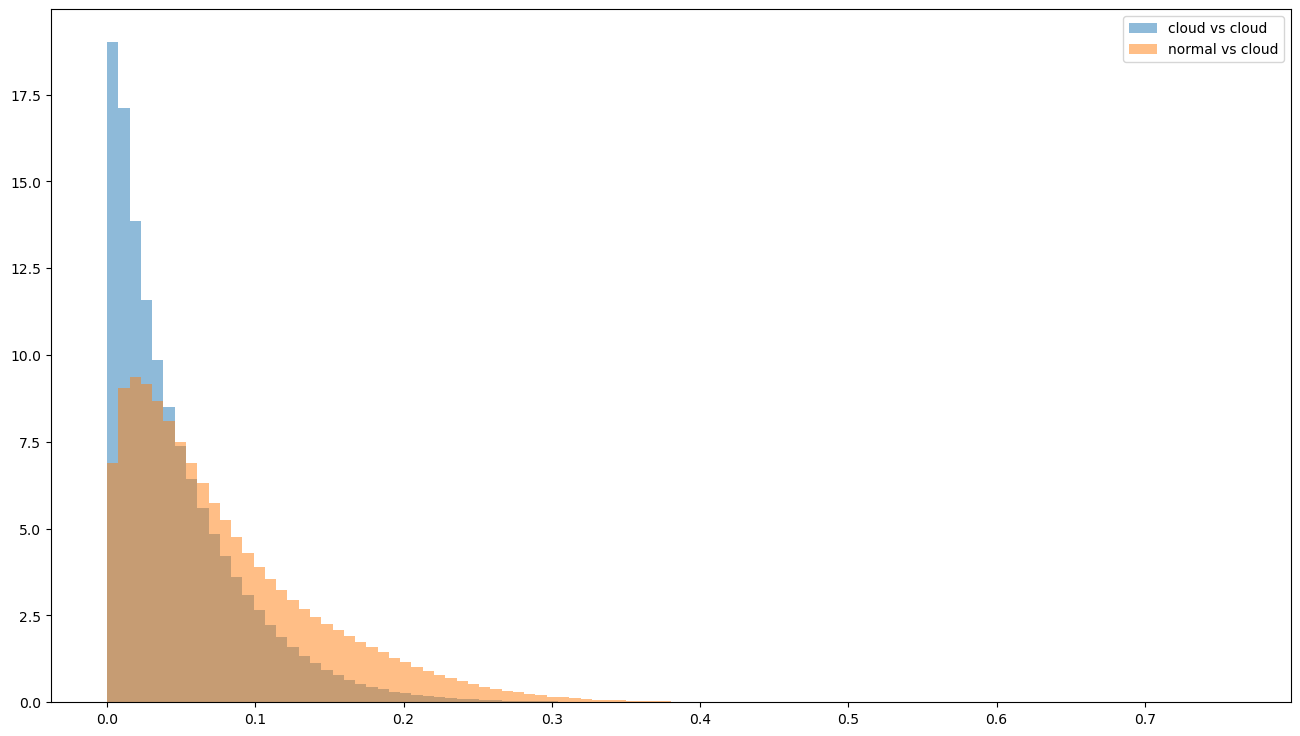

dial with 2 pixels
with water time slice 0
12680
990980


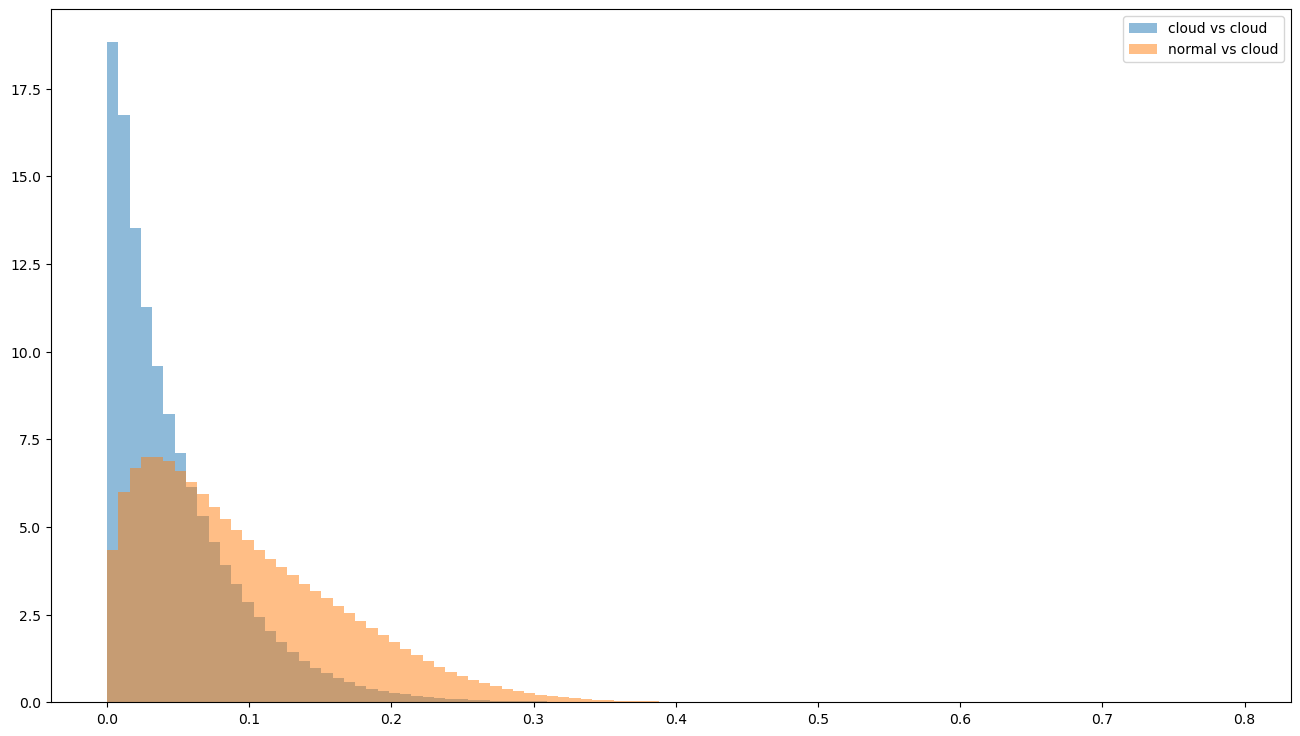

dial with 3 pixels
with water time slice 0
11312
990980


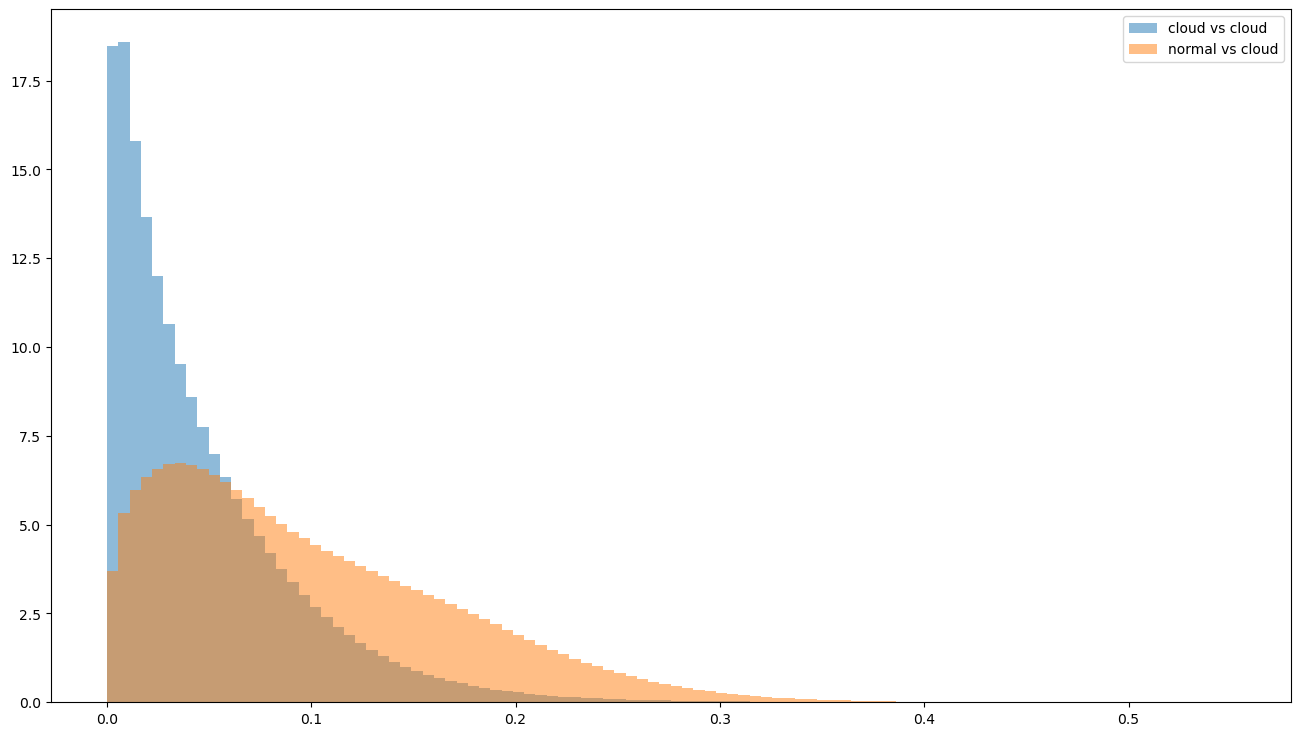

dial with 4 pixels
with water time slice 0
10417
990980


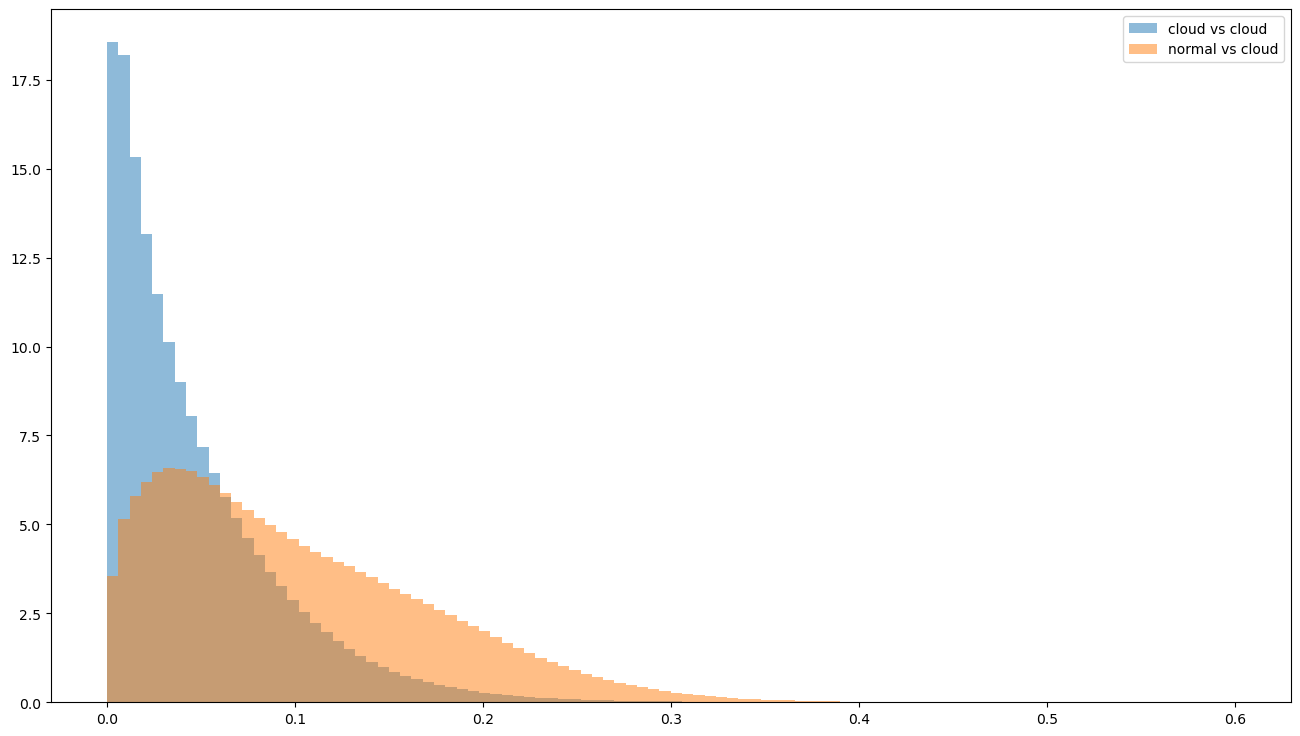

dial with 5 pixels
with water time slice 0
9661
990980


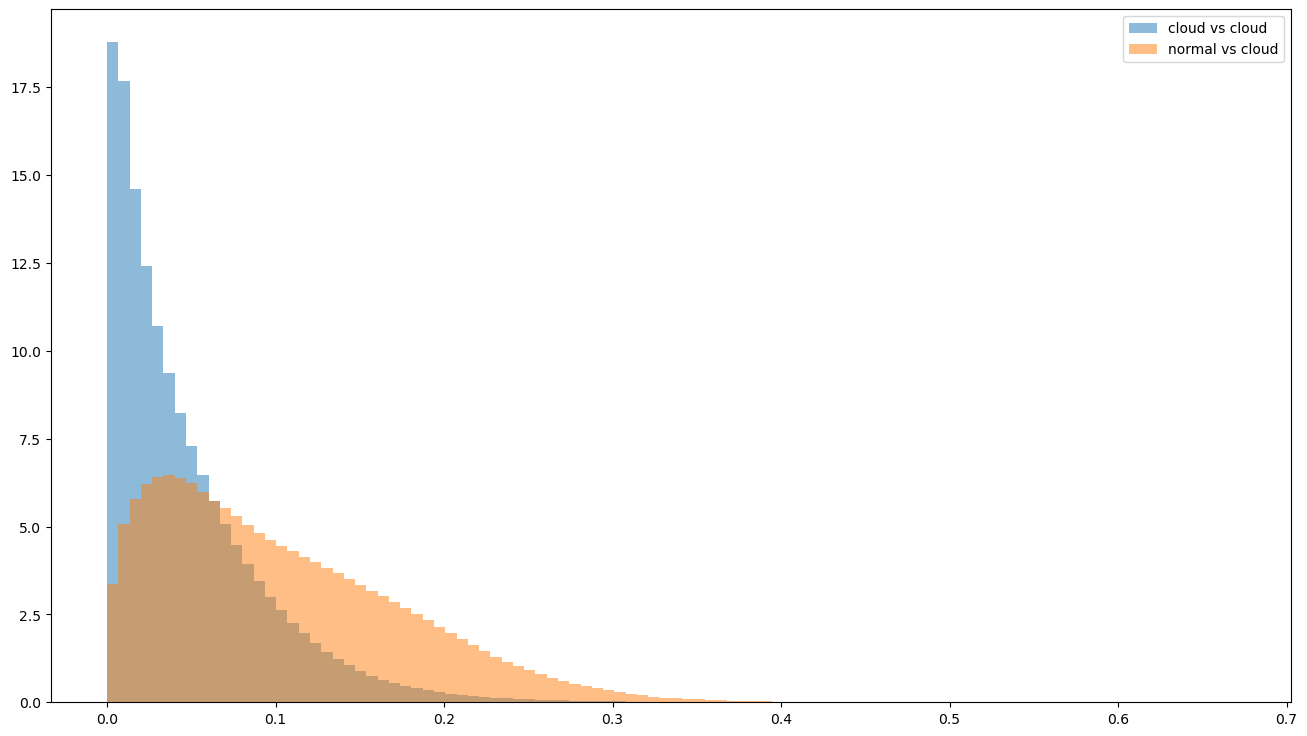

dial with 6 pixels
with water time slice 0
9001
990980


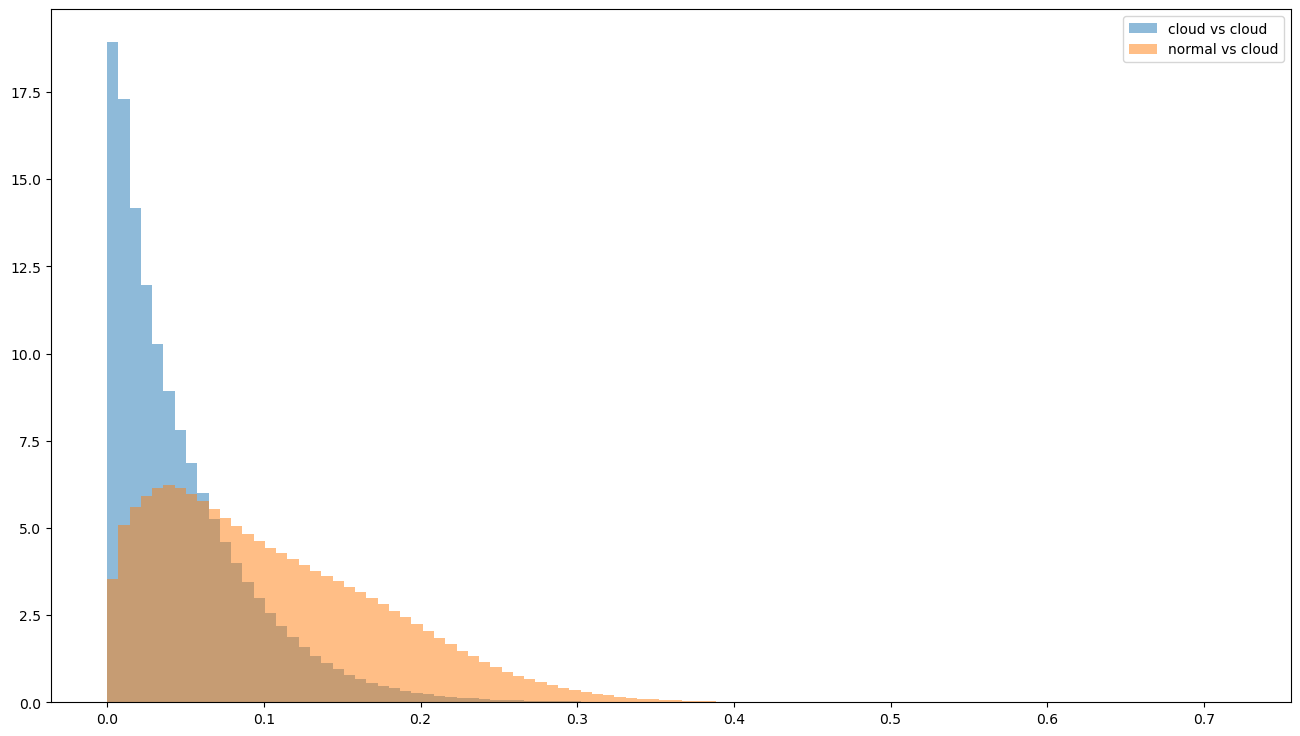

dial with 7 pixels
with water time slice 0
8544
990980


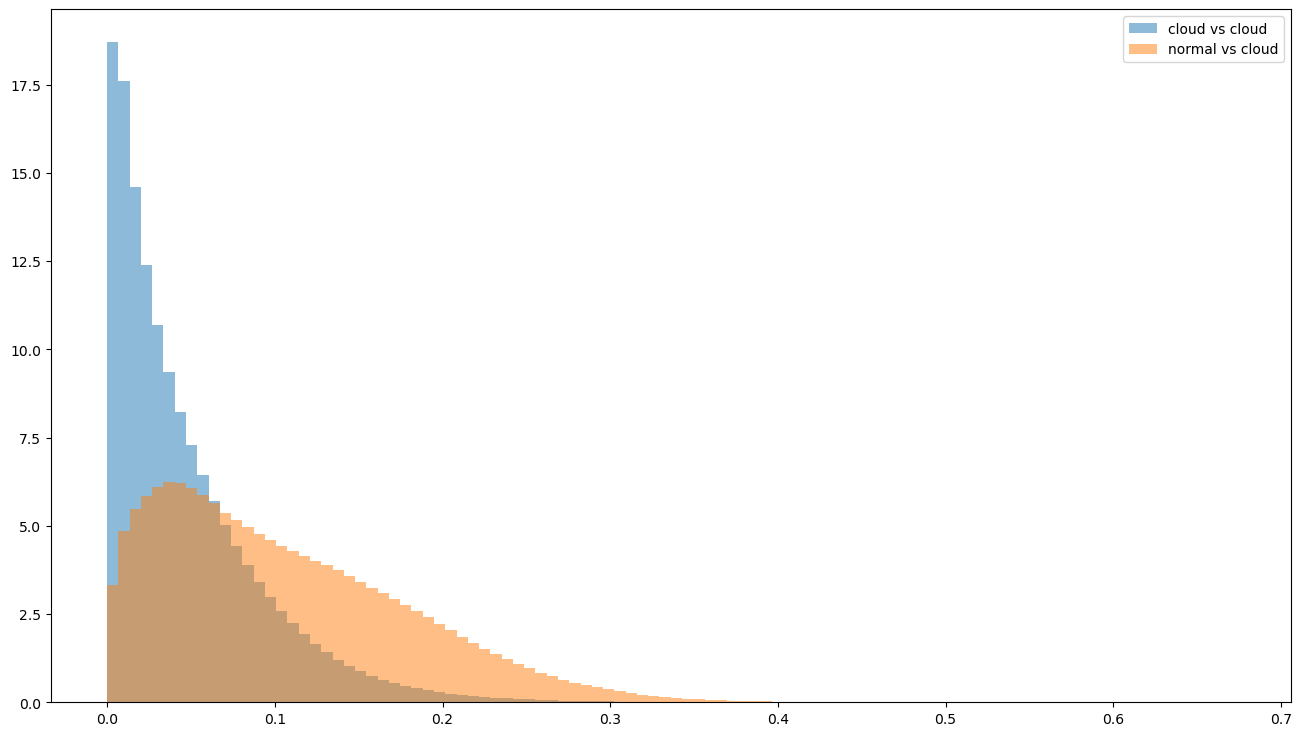

dial with 8 pixels
with water time slice 0
8201
990980


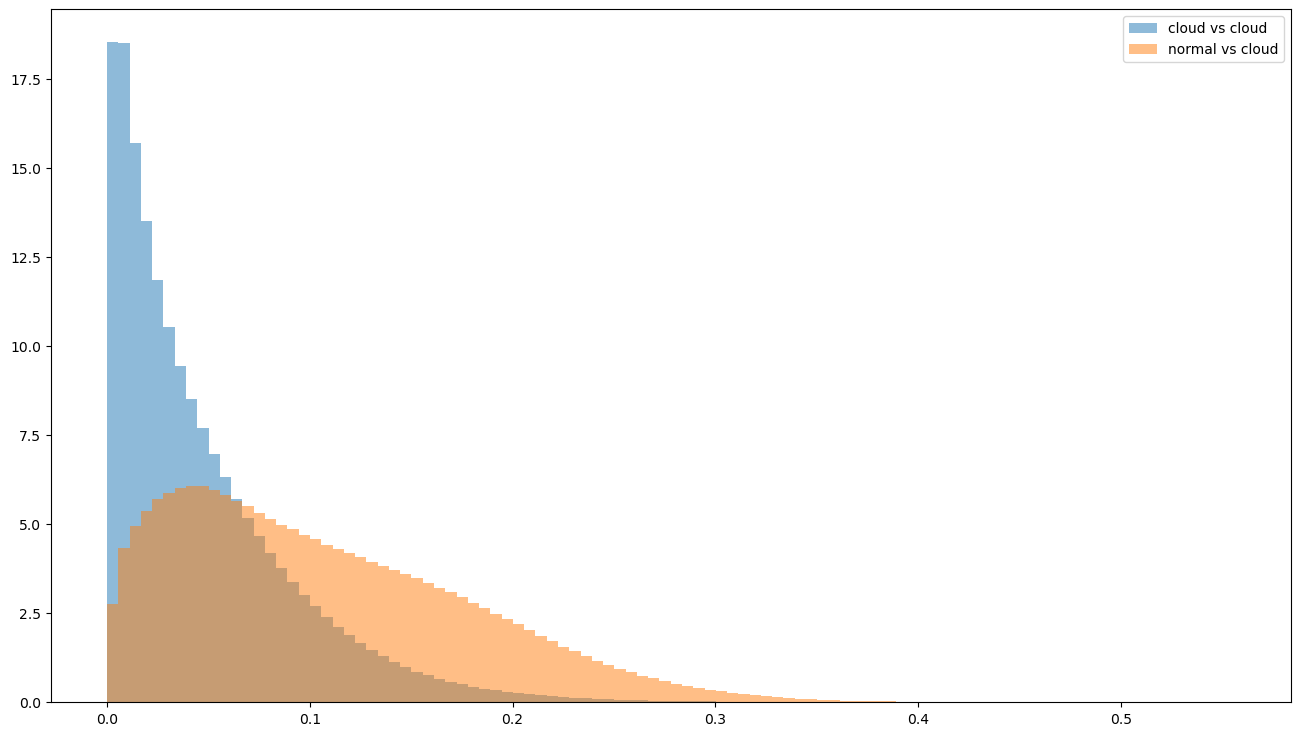

dial with 9 pixels
with water time slice 0
7854
990980


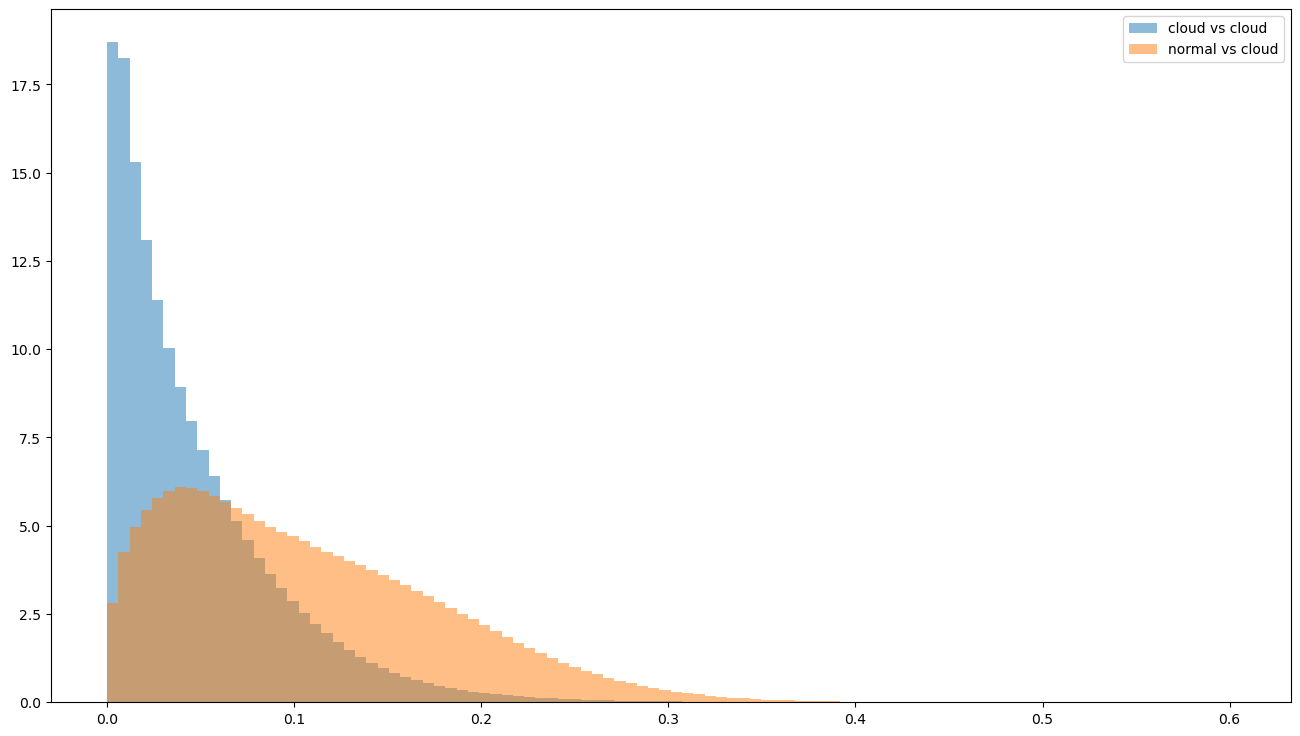

In [131]:
data_tmp = data_array.where(c3_land_raster, -999)
for dial_pixel_no in dial_pixel_trial_list:
    print(f"dial with {dial_pixel_no} pixels")
    time_slice = 0
    cloud_ids, normal_ids, cloud_shadow_dilated = generate_idx(cloud_mask, shadow_mask, int(dial_pixel_no))
    while True:
        if time_slice >= data_array.shape[1]:
            break
        with_water = True

        # require dask >= 2022.5.1 to make this work, otherwise np.ravel_mutli_index
        cloud_idx = da.ravel_multi_index((cloud_ids.data[time_slice][0].flatten(),
                                          cloud_ids.data[time_slice][1].flatten()), 
                                          cloud_ids.data.shape[2:])
        cloud_idx = cloud_idx[cloud_idx > 0]
        normal_idx = da.ravel_multi_index((normal_ids.data[time_slice][0].flatten(),
                                           normal_ids.data[time_slice][1].flatten()), 
                                           normal_ids.data.shape[2:])
        normal_idx = normal_idx[normal_idx > 0]

        # no need for this cell if np.ravel_multi_index is used
        cloud_idx = cloud_idx.compute()
        normal_idx = normal_idx.compute()

        if (~(water_mask.where(c3_land_raster, 0))[time_slice].data.flatten()[normal_idx].any()):
            time_slice += 1
            print(f"no water next {time_slice}")
            continue
        cloud_array = []
        normal_array = []
        water_array = []
        for i in range(data_array.shape[0]):
            cloud_tmp = data_tmp[i, time_slice].data.flatten()[cloud_idx]
            cloud_tmp = cloud_tmp[cloud_tmp > -999]
            normal_tmp = data_tmp.where(water_mask > 0, -999)[i, time_slice].data.flatten()[normal_idx]
            normal_tmp = normal_tmp[normal_tmp > -999]
            cloud_array += [cloud_tmp.compute()]
            normal_array += [normal_tmp.compute()]

        print(f"with water time slice {time_slice}")
        cloud_array = da.stack(cloud_array)
        normal_array = da.stack(normal_array)
        normal_array_size = normal_array.shape[1]
        cloud_array_size = cloud_array.shape[1]

        print(normal_array_size)
        print(cloud_array_size)

        normal_cos_dis = cdist(cloud_array.T.astype(float)[np.random.uniform(0, cloud_array_size, 10000).astype(int)], 
                                normal_array.T.astype(float)[np.random.uniform(0, normal_array_size, 10000).astype(int)],
                                "cosine")

        cloud_cos_dis = cdist(cloud_array.T.astype(float)[np.random.uniform(0, cloud_array_size, 10000).astype(int)], 
                              cloud_array.T.astype(float)[np.random.uniform(0, cloud_array_size, 10000).astype(int)],
                              "cosine")

        fig = plt.figure(figsize=(16, 9))
        c_dens, c_bins, _= plt.hist(cloud_cos_dis.reshape(-1), bins=100, alpha=0.5, label="cloud vs cloud", density=True)
        n_dens, n_bins, _= plt.hist(normal_cos_dis.reshape(-1), bins=c_bins, alpha=0.5, label="normal vs cloud", density=True)
        plt.legend(loc="upper right")
        plt.show()
        break
    density_change += [(c_dens[0] - n_dens[0])/c_dens[0]]

In [102]:
client.close()
client = start_local_dask(n_workers=1, threads_per_worker=8, memory_limit='56GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/emma.ai@ga.gov.au/proxy/8787/status,
Dashboard: /user/emma.ai@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 8,Total memory: 52.15 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39865,Workers: 1
Dashboard: /user/emma.ai@ga.gov.au/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 52.15 GiB
Comm: tcp://127.0.0.1:34697,Total threads: 8
Dashboard: /user/emma.ai@ga.gov.au/proxy/32883/status,Memory: 52.15 GiB
Nanny: tcp://127.0.0.1:45765,


In [132]:
np.array(density_change)[1:] - np.array(density_change)[:-1]

array([ 0.13132333,  0.03038453,  0.00901257,  0.01294514, -0.00746545,
        0.00786179,  0.0290048 , -0.00148343])

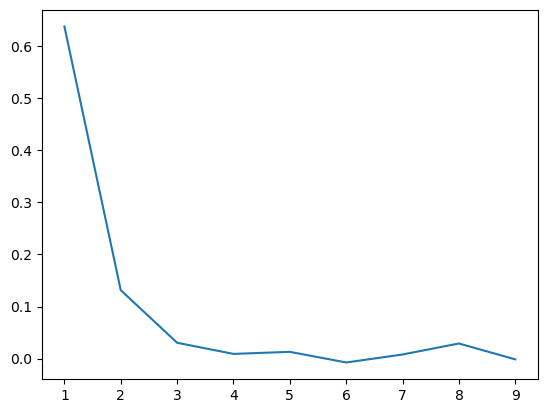

In [133]:
plt.plot(dial_pixel_trial_list, [density_change[0]] + list(np.array(density_change)[1:] - np.array(density_change)[:-1]))